# Open Ended Section

In this file we'll be backing the thing we said in the handout. Which were:

"In this section, we explore how our findings can be applied in real-world scenarios. For instance, the 
identification of high-risk counties and injury types can help insurance companies adjust their risk 
management strategies and allocate resources more effectively. Additionally, employers could benefit 
by implementing safety training and preventive measures in high-risk areas, ultimately leading to 
reduced claims and improved worker well-being. Ultimately, the end goal is to save money, by 
automatizing this process or to avoid giving compensation for those you don’t meet the criteria. 
This open-ended discussion aims to ensure the analysis is not only academic but also actionable, 
highlighting how data-driven insights can contribute to tangible improvements in workplace safety and 
insurance practices."

In [10]:
# Standard libraries
import time
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import (
    GridSearchCV, PredefinedSplit, KFold, StratifiedKFold, train_test_split, cross_val_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer
)
from imblearn.over_sampling import SMOTE

from Preprocessing_functions import *

import importlib
imported_module = importlib.import_module("Preprocessing_functions")
importlib.reload(imported_module)

# pandas max columns display
pd.set_option('display.max_columns', None)

In [41]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

C:\Users\isa\AppData\Local\Temp\ipykernel_25992\3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


In [42]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]

In [66]:
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached','OIICS Nature of Injury Description'])
y = train_data['Claim Injury Type']

test_data = test_data.drop(columns=['OIICS Nature of Injury Description'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

## Simple model with holdout method

In [21]:
CODE_COLUMNS = ['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

DESCRIPTION_COLUMNS = ['WCIO Cause of Injury Description','WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

BOOLEAN_COLUMNS = ['Alternative Dispute Resolution', 'Attorney/Representative','COVID-19 Indicator']

date_order = ['Accident Date', 'C-2 Date','C-3 Date','Assembly Date', 'First Hearing Date']

numerical_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'C-2 Date', 
    'C-3 Date', 
    'First Hearing Date', 
    'IME-4 Count', 
]

outliers_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year',
    'IME-4 Count', 
]

categorical_features = ['Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name',
 'Gender',
 'Industry Code',
 'Medical Fee Region',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']


columns_to_scale = ['Accident Date',
                'Assembly Date',
                'Average Weekly Wage',
                'Age at Injury',
                'Birth Year', 
                'Number of Dependents',
                'IME-4 Count']

date_columns = ['Accident Date', 'Assembly Date']

outliers_iqr_specific = ['Age at Injury', 'Birth Year']

columns_to_drop = ['C-2 Date', 'C-3 Date', 'First Hearing Date']

low_cardinality_cols = [col for col in categorical_features if X[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_features if X[col].nunique() > 10]

In [22]:


def preprocessing_scaling_encoding_dum(X_train, X_val):
    X_train, X_val = type_conversion_categorical(X_train, X_val,categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = scaling_robust(X_train, X_val, columns_to_scale)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val

In [18]:
X_train_processed, X_val_processed = preprocessing_scaling_encoding_dum(X_train, X_val)

c:\Users\isa\Documents\Github\ML_Group36\src\Preprocessing_functions.py:416: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
c:\Users\isa\Documents\Github\ML_Group36\src\Preprocessing_functions.py:417: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [19]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_processed, y_train)
y_pred = log_reg.predict(X_val_processed)

print(classification_report(y_val, y_pred))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

                 precision    recall  f1-score   support

   1. CANCELLED       0.41      0.04      0.07      2496
    2. NON-COMP       0.81      0.96      0.88     58216
    3. MED ONLY       0.22      0.04      0.07     13781
   4. TEMPORARY       0.66      0.81      0.73     29702
5. PPD SCH LOSS       0.61      0.39      0.48      9656
     6. PPD NSL       0.00      0.00      0.00       842
         7. PTD       0.00      0.00      0.00        19
       8. DEATH       0.00      0.00      0.00        94

       accuracy                           0.73    114806
      macro avg       0.34      0.28      0.28    114806
   weighted avg       0.67      0.73      0.68    114806



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
train_data.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code', 'Industry Code Description', 'Medical Fee Region',
       'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code', 'Agreement Reached',
       'WCB Decision', 'Number of Dependents'],
      dtype='object')

___

# Risk Analysis

In [23]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   ---------------------------------------  317.4/323.6 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 323.6/323.6 kB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   -- ------------------------------------- 1.1/16.2 MB 23.7 MB/s eta 0:00:01
   ------- -------------------------------- 3.2/16.2 MB 28.8 MB/s eta 0:00:01
   -------------- ------------------------- 5.7/16.2 MB 40.7 MB/s eta 0:00:01
   ------------------ --------------------- 7.5/16.2 MB 43.8 MB/s eta 0:00:01
   ------------------------- -------------- 10.4/16.2 MB 40.9 MB/s eta 0:00:01
   -------------------------------------- - 15.5/16.2 MB 65.6 MB/s eta 0:00:01
   ---------------------------------------- 16.2/16.2 MB 59.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [45]:
geo_file = 'new-york-counties.geojson'
ny_counties = gpd.read_file(geo_file)

In [42]:
print(ny_counties.columns)
print(claims_by_county.columns)

Index(['geoid', 'name', 'geometry', 'County of Injury_x', 'Claim Count_x',
       'County of Injury_y', 'Claim Count_y', 'County of Injury',
       'Claim Count'],
      dtype='object')
Index(['County of Injury', 'Claim Count'], dtype='object')


In [46]:
# Preprocess data to calculate claim counts by county
claims_by_county = train_data.groupby('County of Injury').size().reset_index(name='Claim Count')

#Add " County" to the county names to match the geojson file to capitalize the first letter of each word
claims_by_county['County of Injury'] = claims_by_county['County of Injury'].str.title() + ' County'


ny_counties = ny_counties.merge(claims_by_county, left_on='name', right_on='County of Injury', how='left')
ny_counties['Claim Count'] = ny_counties['Claim Count'].fillna(0)  # Fill missing values with 0

<Figure size 1200x800 with 0 Axes>

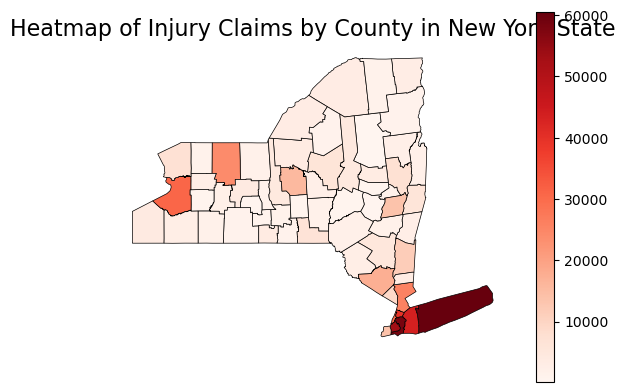

In [47]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = ny_counties.plot(column='Claim Count', cmap='Reds', legend=True, edgecolor='black', linewidth=0.5)
ax.set_title('Heatmap of Injury Claims by County in New York State', fontsize=16)
ax.set_axis_off()
plt.show()

In [48]:
# Industry Analysis
industry_claims = train_data.groupby('Industry Code Description').size().reset_index(name='Claim Count')
industry_claims = industry_claims.sort_values(by='Claim Count', ascending=False).head(10)  # Top 10 industries

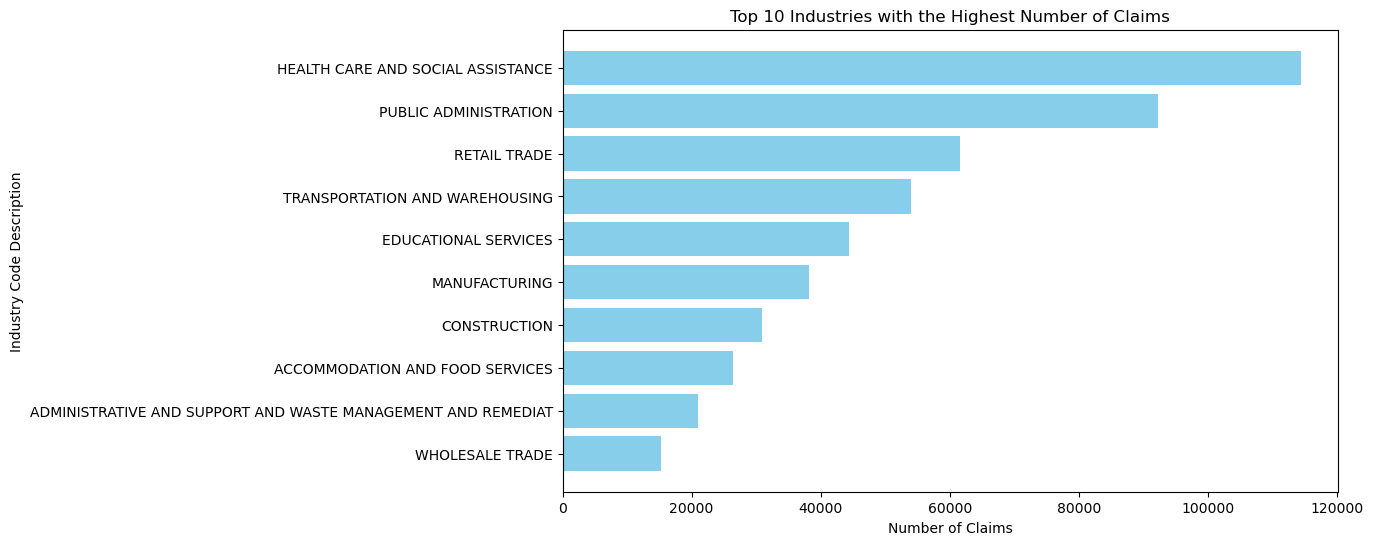

In [49]:
plt.figure(figsize=(10, 6))
plt.barh(industry_claims['Industry Code Description'], industry_claims['Claim Count'], color='skyblue')
plt.xlabel('Number of Claims')
plt.ylabel('Industry Code Description')
plt.title('Top 10 Industries with the Highest Number of Claims')
plt.gca().invert_yaxis()
plt.show()

In [52]:
# WCIO Cause of Injury Analysis
injury_causes = train_data.groupby('WCIO Cause of Injury Description').size().reset_index(name='Claim Count')
injury_causes = injury_causes.sort_values(by='Claim Count', ascending=False).head(10)  # Top 10 injury causes

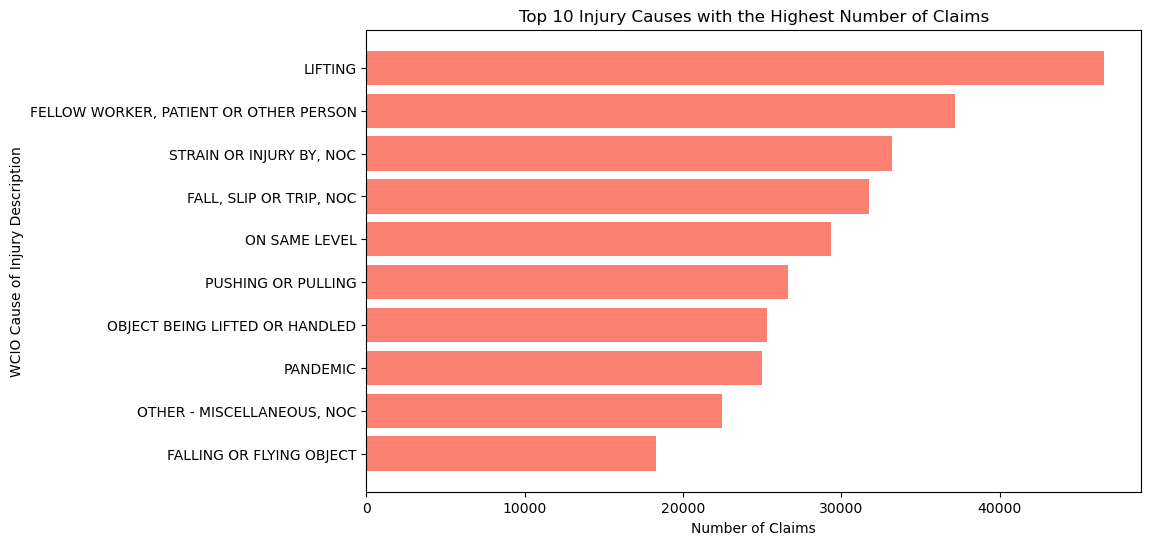

In [53]:
# Plot Injury Causes Analysis
plt.figure(figsize=(10, 6))
plt.barh(injury_causes['WCIO Cause of Injury Description'], injury_causes['Claim Count'], color='salmon')
plt.xlabel('Number of Claims')
plt.ylabel('WCIO Cause of Injury Description')
plt.title('Top 10 Injury Causes with the Highest Number of Claims')
plt.gca().invert_yaxis()
plt.show()

___
## XBoost Model

In [2]:
import os
import pickle

In [4]:
with open('wcb_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [88]:
form_data = {
    'Accident Date': '2023-12-14',
    'Age at Injury': 35,
    'Assembly Date': '2022-06-01',
    'Average Weekly Wage': 750.50,
    'Birth Year': 1988,
    'IME-4 Count': 2,
    'Number of Dependents': 3,
    'Attorney/Representative': 'True',
    'COVID-19 Indicator': 'False',
    'Carrier Name': 'Example Carrier',
    'County of Injury': 'Kings County',
    'Industry Code': '12345',
    'WCIO Cause of Injury Code': '01',
    'WCIO Nature of Injury Code': '05',
    'WCIO Part Of Body Code': '10',
    'Zip Code': '11201',
    'District Name': 'NYC',
    'Gender': 'M',
    'Medical Fee Region': 'Region IV',
    'Carrier Type': '1A. PRIVATE'
}

# Convert form data into a DataFrame
data = pd.DataFrame([form_data])



In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

def preprocess_form_input(data):
    """
    Preprocesses the input DataFrame from the form by applying all transformations
    in the correct feature order, handling missing columns gracefully.
    """
    # Define the correct feature order
    feature_order = [
        'Accident Date',
        'Age at Injury',
        'Assembly Date',
        'Average Weekly Wage',
        'Birth Year',
        'IME-4 Count',
        'Number of Dependents',
        'Attorney/Representative_False',
        'Attorney/Representative_True',
        'Carrier Type_1A. PRIVATE',
        'Carrier Type_2A. SIF',
        'Carrier Type_3A. SELF PUBLIC',
        'COVID-19 Indicator_False',
        'COVID-19 Indicator_True',
        'District Name_NYC',
        'Gender_F',
        'Gender_M',
        'Medical Fee Region_IV',
        'Carrier Name',
        'County of Injury',
        'Industry Code',
        'WCIO Cause of Injury Code',
        'WCIO Nature of Injury Code',
        'WCIO Part Of Body Code',
        'Zip Code'
    ]

    # Ensure all expected columns exist in the input DataFrame
    for col in feature_order:
        if col not in data.columns:
            # Initialize missing columns with default values
            if col in ['Attorney/Representative_False', 'Attorney/Representative_True',
                       'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF',
                       'Carrier Type_3A. SELF PUBLIC', 'COVID-19 Indicator_False',
                       'COVID-19 Indicator_True', 'District Name_NYC',
                       'Gender_F', 'Gender_M', 'Medical Fee Region_IV']:
                data[col] = 0  # Default for boolean columns
            else:
                data[col] = np.nan  # Default for other columns

    # Process numerical columns for scaling
    scale_form = [
        'Accident Date', 'Assembly Date', 'Average Weekly Wage',
        'Age at Injury', 'Birth Year', 'Number of Dependents', 'IME-4 Count'
    ]
    scaler = RobustScaler()
    for col in scale_form:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
            data[col] = scaler.fit_transform(data[[col]])

    # Process categorical columns for frequency encoding
    encoding_frequency1_form = [
        'Carrier Name', 'Industry Code', 'WCIO Cause of Injury Code',
        'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
        'Zip Code', 'County of Injury'
    ]
    for col in encoding_frequency1_form:
        if col in data.columns:
            freq_dict = data.groupby(col).size() / len(data)
            data[col] = data[col].map(freq_dict).fillna(0)

    # Process date columns to timestamps
    date_form = ['Accident Date', 'Assembly Date']
    for col in date_form:
        if col in data.columns:
            data[col] = pd.to_datetime(data[col], errors='coerce')
            data[col] = data[col].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

    # Ensure final DataFrame columns are in the correct order
    data = data[feature_order]

    return data


In [91]:
processed_data = preprocess_form_input(data)
processed_data.columns

Index(['Accident Date', 'Age at Injury', 'Assembly Date',
       'Average Weekly Wage', 'Birth Year', 'IME-4 Count',
       'Number of Dependents', 'Attorney/Representative_False',
       'Attorney/Representative_True', 'Carrier Type_1A. PRIVATE',
       'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC',
       'COVID-19 Indicator_False', 'COVID-19 Indicator_True',
       'District Name_NYC', 'Gender_F', 'Gender_M', 'Medical Fee Region_IV',
       'Carrier Name', 'County of Injury', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Zip Code'],
      dtype='object')

In [77]:
e

In [93]:
loaded_model.predict(processed_data)

array([2], dtype=int64)

In [71]:
data.head()

,Accident Date,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,IME-4 Count,Number of Dependents,Attorney/Representative_False,Attorney/Representative_True,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,COVID-19 Indicator_False,COVID-19 Indicator_True,District Name_NYC,Gender_F,Gender_M,Medical Fee Region_IV,Carrier Name,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,County of Injury
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,True,False,False,True,False,True,False,True,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [58]:
# Retrieve the expected feature names from the model
expected_features = loaded_model.get_booster().feature_names

# Reorder the DataFrame to match the expected feature names
data = data[expected_features]

for feature in expected_features:
    if feature not in data.columns:
        data[feature] = 0  # Or an appropriate default value

data = data[expected_features]

In [59]:
# Retrieve expected feature names
expected_features = loaded_model.get_booster().feature_names

# Reorder and align feature names
data = data.reindex(columns=expected_features, fill_value=0)

# Ensure the data is in the correct format
data = data.astype(float)  # Convert all values to float (or appropriate type)

# Make predictions
predictions = loaded_model.predict(data)